In [209]:
from yfinance import Ticker, download
import pandas as pd
import numpy as np
from scipy.stats import kendalltau, spearmanr
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.fft import fft, fftfreq, ifft
import numpy, scipy.optimize
from sklearn.preprocessing import minmax_scale
import pylab as plt

## Loading Crypto Data and Extract df of Close prices

In [3]:
avail_cryptos = pd.read_excel("yf-crypto-tickers.xlsx").set_index("Unnamed: 0")["Tickers"]
df_close = pd.DataFrame()

for i in range(len(avail_cryptos)):
    df = Ticker(avail_cryptos[i]).history(period="1y")["Close"].rename(avail_cryptos[i])
    df_close = pd.concat([df_close, df], axis=1)
    
df_close = df_close.dropna(axis=1)

- BUSD2-USD: No data found, symbol may be delisted
- BUSD1-USD: No data found, symbol may be delisted
- EUR2-USD: No data found, symbol may be delisted
- TRY1-USD: No data found, symbol may be delisted


In [4]:
def get_crypto_df(ticker):
    df = Ticker(ticker).history(period="1y")["Close"].rename(ticker)
    return df

# Example of a lagged rolling correlation between BTC and ETH

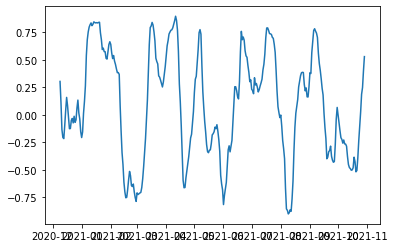

In [155]:
def lag_roll_corr(series1, series2, lag):
    """
    Inputs:
    - series1: series 1 who's current day values have their rolling correlation taken with series2's future lagged values - the hypothethical independent variable
    - series2: the series which has it's future values correlated with series1's past values - the hypothetical dependent variable
    Outputs:
    - lagged rolling correlation with series 1 current day values correlated with series 2 future lagged values
    """
    pair = pd.concat([series1, series2], axis=1)
    pair.iloc[:, 0] = pair.iloc[:, 0].shift(lag)
    lagged_rcorr = pair.iloc[:, 0].rolling(lag).corr(pair.iloc[:, 1])
    lagged_rcorr = lagged_rcorr.dropna()
    return lagged_rcorr

def lag_roll_kendall(series1, series2, lag):
    """
    Inputs:
    - series1: series 1 who's current day values have their rolling kendall tau taken with series2's future lagged values - the hypothethical independent variable
    - series2: the series which has it's future values correlated with series1's past values - the hypothetical dependent variable
    Outputs:
    - lagged rolling correlation with series 1 current day values rank correlated (kendall tau) with series 2 future lagged values
    """
    ken_values = []
    series2 = series2.shift(-lag).dropna()
    
    for i in range(0, len(series2)-lag+1):
        ken_values.append(kendalltau(series1[0+i:lag+i], series2[0+i:lag+i])[0])

    return pd.DataFrame(ken_values).set_index(series1.index[lag-1:len(btc)-lag])

def lag_roll_spearman(series1, series2, lag):
    """
    Inputs:
    - series1: series 1 who's current day values have their rolling kendall tau taken with series2's future lagged values - the hypothethical independent variable
    - series2: the series which has it's future values correlated with series1's past values - the hypothetical dependent variable
    Outputs:
    - lagged rolling correlation with series 1 current day values rank correlated (spearman r) with series 2 future lagged values
    """
    ken_values = []
    series2 = series2.shift(-lag).dropna()
    
    for i in range(0, len(series2)-lag+1):
        ken_values.append(spearmanr(series1[0+i:lag+i], series2[0+i:lag+i])[0])

    return pd.DataFrame(ken_values).set_index(series1.index[lag-1:len(btc)-lag])


# example of how to run the functions
lag = 21
btc = df_close.iloc[:, 0]
eth = df_close.iloc[:, 1]
lag_rollktau = lag_roll_kendall(btc, eth, lag)
lag_roll_spearr = lag_roll_spearman(btc, eth, lag)
lag_roll_pears = lag_roll_corr(btc, eth, lag)

plt.plot(lag_roll_pears)

COTI-USD


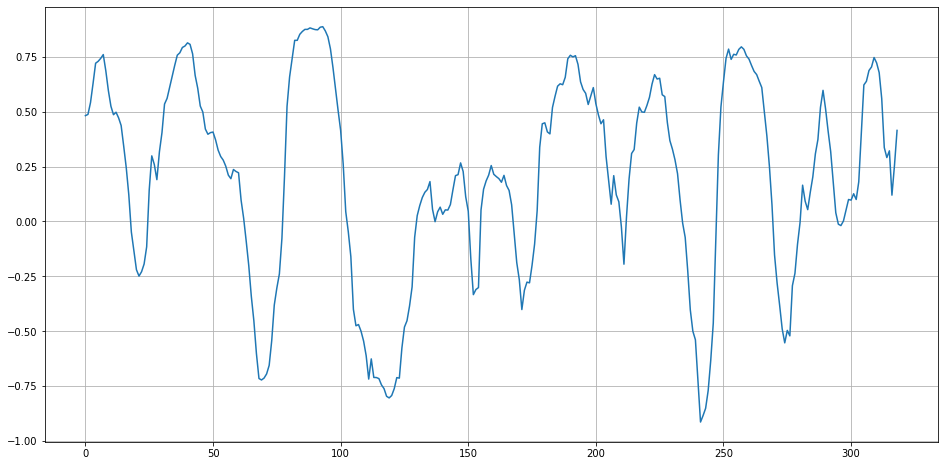

In [156]:
lag = 24
btc = df_close.iloc[:, 0]
dependent_var = df_close.iloc[:, 25]

print(dependent_var.name)

lag_roll_pears = lag_roll_corr(btc, dependent_var, lag)

plt.figure(figsize=(16,8))
plt.plot(np.arange(0, len(lag_roll_pears), 1), lag_roll_pears) # plotting lagged rolling pearson correlation
plt.grid()
plt.show()

# Fitting a sinewave to the data

In [157]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess, maxfev=5000)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

tt = np.arange(0, len(lag_roll_pears), 1)
res = fit_sin(tt, lag_roll_pears)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

Amplitude=-0.3072571034744997, Angular freq.=0.11687450820074326, phase=0.0824655082827852, offset=0.1960762336620999, Max. Cov.=0.044040340277709256


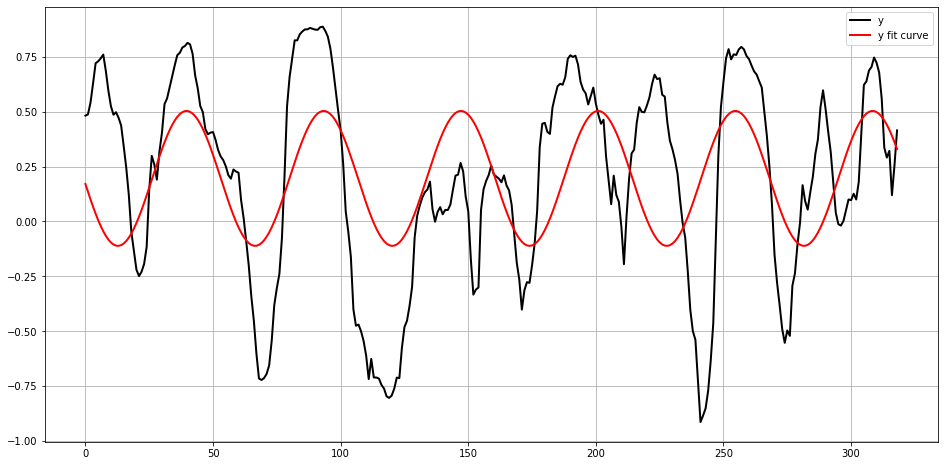

In [158]:
plt.figure(figsize=(16,8))
plt.plot(tt, lag_roll_pears, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

## Error Functions between Sine and Original

In [159]:
# MSE
mse = sum((lag_roll_pears.values - res["fitfunc"](tt))**2)

# MAE
mae = sum(abs(lag_roll_pears.values - res["fitfunc"](tt)))


## Putting it all together and finding the lags that correspond closest to a period sine wave

In [160]:
btc = df_close.iloc[:, 0]
dependent_var = df_close.iloc[:, 2]

output = []

for lag in range(2, 45):
    
    #print(lag)

    # obtaining the correlations
    lag_roll_pears = lag_roll_corr(btc, dependent_var, lag)

    # generating the sinewave
    tt = np.arange(0, len(lag_roll_pears), 1)
    res = fit_sin(tt, lag_roll_pears)

    # error functions
    mse = sum((lag_roll_pears.values - res["fitfunc"](tt))**2)
    mae = sum(abs(lag_roll_pears.values - res["fitfunc"](tt)))
    period = int((2*np.pi)/res["omega"])
    output.append([lag, mse, mae, period, btc.name, dependent_var.name])
    
display(output)

[[2, 351.2555328936401, 351.2555342316893, 5, 'BTC-USD', 'DOGE-USD'],
 [3, 177.40379526735816, 225.3764849025553, 16, 'BTC-USD', 'DOGE-USD'],
 [4, 140.87243554639196, 196.82420210963755, 20, 'BTC-USD', 'DOGE-USD'],
 [5, 104.90969486141388, 164.09441327200997, 17, 'BTC-USD', 'DOGE-USD'],
 [6, 94.18449678495786, 157.91975034884166, 39, 'BTC-USD', 'DOGE-USD'],
 [7, 90.13647976424163, 151.09040603937837, 38, 'BTC-USD', 'DOGE-USD'],
 [8, 88.9326248758369, 151.83809265007085, 69, 'BTC-USD', 'DOGE-USD'],
 [9, 73.11682761972534, 137.62670927815364, 70, 'BTC-USD', 'DOGE-USD'],
 [10, 68.62482319113839, 133.02289308265958, 37, 'BTC-USD', 'DOGE-USD'],
 [11, 77.81277014879817, 142.46262064044888, 41, 'BTC-USD', 'DOGE-USD'],
 [12, 66.72955232550686, 126.91595183693383, 311, 'BTC-USD', 'DOGE-USD'],
 [13, 69.72805491050164, 129.69771021878552, 308, 'BTC-USD', 'DOGE-USD'],
 [14, 73.56918055310723, 134.51103638886113, 37, 'BTC-USD', 'DOGE-USD'],
 [15, 62.81488517535496, 122.57543233953508, 37, 'BTC-USD'

### Getting IDX of minimum MSEs or MAEs

In [161]:
mses = pd.DataFrame(output)[1].values
maes = pd.DataFrame(output)[2].values

k = 3

top_lags = pd.DataFrame(output)
columns = ["Lags", "MSE", "MAE", "Periodicity", "Independent Var", "Dependent Var"]
top_lags.columns = columns
top_lags = top_lags[top_lags["Periodicity"] < 100] # periodicity filter
top_lags.nsmallest(k, "MSE")

,Lags,MSE,MAE,Periodicity,Independent Var,Dependent Var
19,21,46.174658,103.589007,33,BTC-USD,DOGE-USD
20,22,46.979870,103.784438,33,BTC-USD,DOGE-USD
40,42,49.344059,99.066025,91,BTC-USD,DOGE-USD


In [162]:
mses = pd.DataFrame(output)[1].values
maes = pd.DataFrame(output)[2].values

k = 3

top_lags = pd.DataFrame(output)
columns = ["Lags", "MSE", "MAE", "Periodicity", "Independent Var", "Dependent Var"]
top_lags.columns = columns

display(top_lags)
top_lags = top_lags[top_lags["Periodicity"] < 100] # periodicity filter

idx = np.argpartition(top_lags["MSE"].values, k) # getting best fits 

top_lags = top_lags.loc[idx[:k]] # keeping top 'k' optimal fits

top_lags

,Lags,MSE,MAE,Periodicity,Independent Var,Dependent Var
0,2,351.255533,351.255534,5,BTC-USD,DOGE-USD
1,3,177.403795,225.376485,16,BTC-USD,DOGE-USD
2,4,140.872436,196.824202,20,BTC-USD,DOGE-USD
3,5,104.909695,164.094413,17,BTC-USD,DOGE-USD
4,6,94.184497,157.919750,39,BTC-USD,DOGE-USD
5,7,90.136480,151.090406,38,BTC-USD,DOGE-USD
6,8,88.932625,151.838093,69,BTC-USD,DOGE-USD
7,9,73.116828,137.626709,70,BTC-USD,DOGE-USD
8,10,68.624823,133.022893,37,BTC-USD,DOGE-USD
9,11,77.812770,142.462621,41,BTC-USD,DOGE-USD


,Lags,MSE,MAE,Periodicity,Independent Var,Dependent Var
17,19,62.355481,122.409241,56,BTC-USD,DOGE-USD
18,20,55.324859,112.922507,33,BTC-USD,DOGE-USD
19,21,46.174658,103.589007,33,BTC-USD,DOGE-USD


# Hypothesis Testing
# Experiment 1: Running function with BTC and ETH as predictors and finding most periodic correlations

### Function to return top lags

In [163]:
def return_top_lags(predictor, predictee, k):

    output = []

    for lag in range(2, 30):

        #print(lag)

        # obtaining the correlations
        lag_roll_pears = lag_roll_corr(predictor, predictee, lag)

        # generating the sinewave
        tt = np.arange(0, len(lag_roll_pears), 1)
        res = fit_sin(tt, lag_roll_pears)

        # error functions
        mse = sum((lag_roll_pears.values - res["fitfunc"](tt))**2)
        mae = sum(abs(lag_roll_pears.values - res["fitfunc"](tt)))
        period = int((2*np.pi)/res["omega"])
        output.append([lag, mse, mae, period, predictor.name, predictee.name])
        
        
    mses = pd.DataFrame(output)[1].values # getting MSEs in df

    top_lags = pd.DataFrame(output) # put all values into dataframe

    columns = ["Lags", "MSE", "MAE", "Periodicity", "Independent Var", "Dependent Var"] # column names
    
    top_lags.columns = columns # set col names

    top_lags = top_lags[top_lags["Periodicity"] < 100] # periodicity filter

    top_lags = top_lags.nsmallest(k, "MSE")
    
    return top_lags

In [164]:
k = 3

per_hy_df = pd.DataFrame()

for j in range(0, 2):

    predictor = df_close.iloc[:, j] 
    
    for i in range(1, len(df_close.columns)-1):
        dependent_var = df_close.iloc[:, i]
        tmp_df = return_top_lags(predictor, dependent_var, k)
        per_hy_df = pd.concat([per_hy_df, tmp_df], axis=0)
    
per_hy_df = per_hy_df.sort_values(by="MSE")

per_hy_df = per_hy_df.reset_index(drop=True)

per_hy_df

,Lags,MSE,MAE,Periodicity,Independent Var,Dependent Var
0,27,13.319980,52.369408,33,ETH-USD,USDT-USD
1,26,16.107252,58.540193,52,ETH-USD,USDT-USD
2,25,19.946011,61.977926,34,ETH-USD,USDT-USD
3,18,20.743992,67.985201,66,BTC-USD,USDT-USD
4,21,21.313587,67.862624,44,BTC-USD,USDT-USD
...,...,...,...,...,...,...
157,18,63.343313,119.726106,36,ETH-USD,VET-USD
158,19,64.106067,119.624302,36,ETH-USD,VET-USD
159,8,69.534883,131.395458,27,ETH-USD,THETA-USD
160,16,73.285618,132.681716,47,ETH-USD,THETA-USD


### Plotting the most period lagged correlation

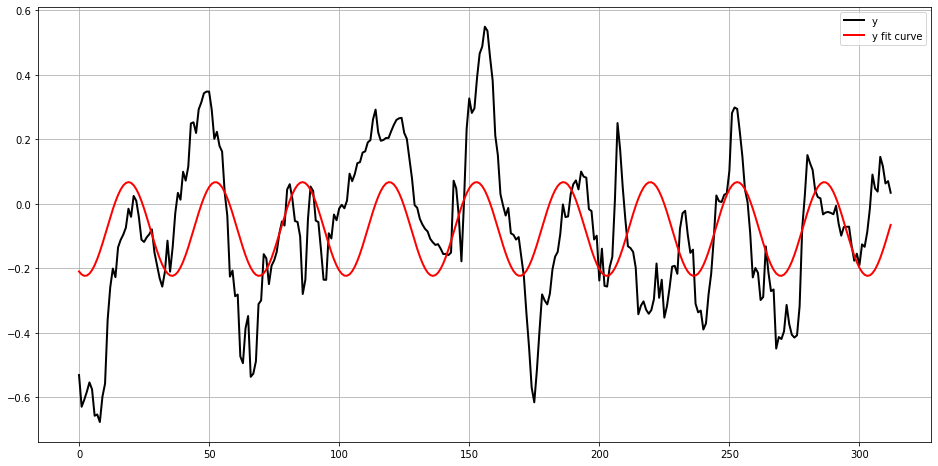

Independent Variable:  ETH-USD - Dependent Variable:  USDT-USD


In [165]:
lags = per_hy_df.iloc[0]["Lags"]

indep = df_close[per_hy_df.iloc[0]["Independent Var"]]

dep = df_close[per_hy_df.iloc[0]["Dependent Var"]]

lag_roll_pears = lag_roll_corr(indep, dep, lags)

# generating the sinewave
tt = np.arange(0, len(lag_roll_pears), 1)
res = fit_sin(tt, lag_roll_pears)

plt.figure(figsize=(16,8))
plt.plot(tt, lag_roll_pears, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

print("Independent Variable: ", per_hy_df.iloc[0]["Independent Var"], "-", "Dependent Variable: ", per_hy_df.iloc[0]["Dependent Var"])

# Experiment 2: Finding lagged correlations with greatest % of values > threshold

### Function to return assets with largest % of lagged correlations greater than threshold value

In [166]:
def return_top_perc(predictor, predictee, k, thresh, lag_range):
    
    output = []
    
    for lag in range(lag_range[0], lag_range[1]):
        lag_roll_pears = lag_roll_corr(predictor, predictee, lag)
        perc = len(lag_roll_pears[abs(lag_roll_pears) > thresh])/len(lag_roll_pears)
        tt = np.arange(0, len(lag_roll_pears), 1)
        res = fit_sin(tt, lag_roll_pears)
        period = int((2*np.pi)/res["omega"])
        output.append([lag, perc, period, predictor.name, predictee.name])
        
    top_perc = pd.DataFrame(output)
    
    columns = ["Lags", "Percentage > {}".format(thresh), "Periodicity", "Independent Var", "Dependent Var"] # column names
    
    top_perc.columns = columns # set col names
    
    top_perc = top_perc[top_perc["Periodicity"] < 100] # periodicity filter
    
    top_perc = top_perc.nlargest(k, "Percentage > {}".format(thresh))
                                  
    return top_perc

In [167]:
thresh = 0.7
k = 3
lag_range = [5, 30]
high_corr = pd.DataFrame()

for j in range(0, 2):

    predictor = df_close.iloc[:, j] 
    
    for i in range(2, len(df_close.columns)-1):
        dependent_var = df_close.iloc[:, i]
        tmp_df = return_top_perc(predictor, dependent_var, k, thresh, lag_range)
        high_corr = pd.concat([high_corr, tmp_df], axis=0)
        
high_corr = high_corr.sort_values(by= "Percentage > {}".format(thresh), ascending=False)

high_corr = high_corr.reset_index(drop=True)

high_corr

,Lags,Percentage > 0.7,Periodicity,Independent Var,Dependent Var
0,5,0.358543,88,BTC-USD,XLM-USD
1,11,0.356522,48,ETH-USD,EGLD-USD
2,5,0.352941,89,BTC-USD,LTC-USD
3,20,0.351682,55,BTC-USD,AVAX-USD
4,5,0.347339,19,ETH-USD,SOL1-USD
...,...,...,...,...,...
151,5,0.218487,32,BTC-USD,USDT-USD
152,6,0.160563,20,BTC-USD,USDT-USD
153,6,0.160563,19,ETH-USD,USDT-USD
154,10,0.112392,64,ETH-USD,USDT-USD


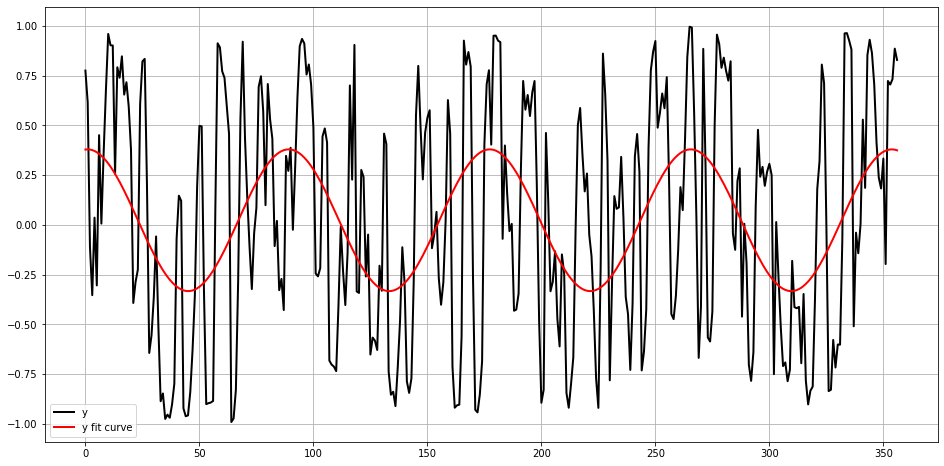

Independent Variable:  BTC-USD - Dependent Variable:  XLM-USD


In [168]:
which_lag = 0

lags = high_corr.iloc[which_lag]["Lags"]

indep = df_close[high_corr.iloc[which_lag]["Independent Var"]]

dep = df_close[high_corr.iloc[which_lag]["Dependent Var"]]

lag_roll_pears = lag_roll_corr(indep, dep, lags)

# generating the sinewave
tt = np.arange(0, len(lag_roll_pears), 1)
res = fit_sin(tt, lag_roll_pears)

plt.figure(figsize=(16,8))
plt.plot(tt, lag_roll_pears, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

print("Independent Variable: ", high_corr.iloc[0]["Independent Var"], "-", "Dependent Variable: ", high_corr.iloc[0]["Dependent Var"])

# Experiment 3: Finding the most accurate directional lagged correlations predicted by sinusoids
- take sign of differenced of the lagged correlations
- take sign of difference of fitted sine waves
- obtain percentage of correctly predicted values

In [169]:
def return_top_dir_lag(predictor, predictee, k):

    output = []

    for lag in range(2, 45):

        #print(lag)

        # obtaining the correlations
        lag_roll_pears = lag_roll_corr(predictor, predictee, lag)

        # generating the sinewave
        tt = np.arange(0, len(lag_roll_pears), 1)
        res = fit_sin(tt, lag_roll_pears)

        corr_diff_sign = np.sign(lag_roll_pears.diff().dropna())

        sine_diff_sign = np.sign(np.diff(res["fitfunc"](tt)))

        tmp = corr_diff_sign - sine_diff_sign

        sign_accuracy = len(tmp[tmp==0])/len(tmp)

        period = int((2*np.pi)/res["omega"])

        output.append([lag, sign_accuracy, period, predictor.name, predictee.name])


    mses = pd.DataFrame(output)[1].values # getting MSEs in df

    top_lags = pd.DataFrame(output) # put all values into dataframe

    columns = ["Lags", "Accuracy", "Periodicity", "Independent Var", "Dependent Var"] # column names

    top_lags.columns = columns # set col names

    top_lags = top_lags[top_lags["Periodicity"] < 100] # periodicity filter

    top_lags = top_lags.nlargest(k, "Accuracy")

    return top_lags

In [170]:
thresh = 0.7
k = 3

top_dir_lags = pd.DataFrame()

for j in range(0, 2):

    predictor = df_close.iloc[:, j] 
    
    for i in range(2, len(df_close.columns)-1):
        dependent_var = df_close.iloc[:, i]
        tmp_df = return_top_dir_lag(predictor, dependent_var, k)
        top_dir_lags = pd.concat([top_dir_lags, tmp_df], axis=0)
        
top_dir_lags = top_dir_lags.sort_values(by= "Accuracy", ascending=False)

top_dir_lags = top_dir_lags.reset_index(drop=True)

top_dir_lags

,Lags,Accuracy,Periodicity,Independent Var,Dependent Var
0,26,0.764331,34,BTC-USD,BNB-USD
1,34,0.761745,60,ETH-USD,BCH-USD
2,28,0.758065,34,BTC-USD,BNB-USD
3,37,0.756849,60,ETH-USD,BCH-USD
4,35,0.756757,60,ETH-USD,BCH-USD
...,...,...,...,...,...
151,11,0.595930,36,ETH-USD,LUNA1-USD
152,11,0.595930,43,ETH-USD,THETA-USD
153,10,0.595376,37,ETH-USD,LUNA1-USD
154,24,0.594340,63,ETH-USD,LUNA1-USD


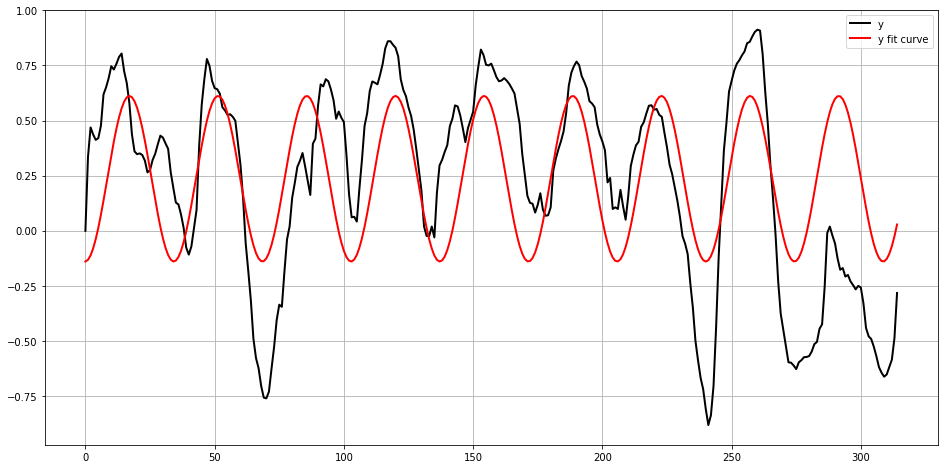

Independent Variable:  BTC-USD - Dependent Variable:  BNB-USD - Lags:  26


In [172]:
which_lag = 0

lags = top_dir_lags.iloc[which_lag]["Lags"]

indep = df_close[top_dir_lags.iloc[which_lag]["Independent Var"]]

dep = df_close[top_dir_lags.iloc[which_lag]["Dependent Var"]]

lag_roll_pears = lag_roll_corr(indep, dep, lags)

# generating the sinewave
tt = np.arange(0, len(lag_roll_pears), 1)
res = fit_sin(tt, lag_roll_pears)

plt.figure(figsize=(16,8))
plt.plot(tt, lag_roll_pears, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

print("Independent Variable: ", top_dir_lags.iloc[which_lag]["Independent Var"], "-", "Dependent Variable: ", top_dir_lags.iloc[which_lag]["Dependent Var"], "-", "Lags: ", lags)

### Plotting the optimal periodic lags

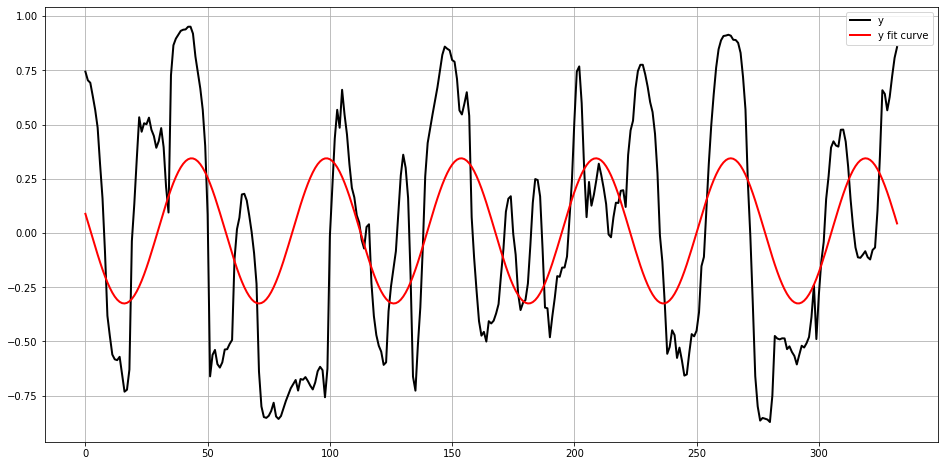

In [206]:
# check the lag plot
lag = idx[0]
btc = df_close.iloc[:, 0]
dependent_var = df_close.iloc[:, 2]

lag_roll_pears = lag_roll_corr(btc, dependent_var, lag)

# generating the sinewave
tt = np.arange(0, len(lag_roll_pears), 1)
res = fit_sin(tt, lag_roll_pears)

plt.figure(figsize=(16,8))
plt.plot(tt, lag_roll_pears, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

# Now we are going to look at market variables during the lagged correlation periods

## Market variable analysis

- We will look at it from the perspective of the market data during the period pertaining to the independent variable
- We will call the independent variable, I, the dependent variable, D, and the lag, N
- We want to know what is happening in the market data of I whenever it produces a point correlation with D for the next N days
- Hence, we implicitly include a look ahead/ forward bias of N days because those N days would be required to obtain the point correlation
- Note: this analysis is purely investigatory and the plots themselves are not directly alpha generative in any shape or form
- The idea is to understand what market variables of I are doing to produce future correlations with D 
- An example conclusion we hope to derive from this analysis is 
    - "Market variable X tends to have a statistically higher mean during periods that I produces a stronger future correlation in D"
- We would go about showing this by plotting the rolling lagged point correlation plot alongside the market variables beginning at time t=N-:
    - This time point represents the time for the first series of I to be loaded in to apply a point correlation with the next N days of D
    - However, in real time we would not have this point correlation as aforementioned due to the requirement of needing the next N days of D 

In [221]:
# top directinal lagged signal
which_lag = 0
lags = top_dir_lags.iloc[which_lag]["Lags"]
indep = df_close[top_dir_lags.iloc[which_lag]["Independent Var"]]
dep = df_close[top_dir_lags.iloc[which_lag]["Dependent Var"]]
lag_roll_pears = lag_roll_corr(indep, dep, lags)
trading_idx = lag_roll_pears.index

In [230]:
dep

2020-10-29     29.842478
2020-10-30     28.508411
2020-10-31     28.431215
2020-11-01     28.461565
2020-11-02     27.883930
                 ...    
2021-10-25    484.645081
2021-10-26    478.025055
2021-10-27    449.007996
2021-10-28    492.015533
2021-10-29    532.300781
Name: BNB-USD, Length: 366, dtype: float64

In [222]:
idx_of_interest = indep[lags-1:-lags].index
lag_roll_pears.index = idx_of_interest


df_indep = Ticker(indep.name).history(period="1y")
indep_volume = df_indep.loc[idx_of_interest]["Volume"]
indep_volume_scaled = minmax_scale(indep_volume, (-1, 1))


df_dep = Ticker(dep.name).history(period="1y")
dep_volume = df_dep.loc[idx_of_interest]["Volume"]
dep_volume_scaled = minmax_scale(dep_volume, (-1, 1))

## Note
- The events from the independent variable at each time point in this plot occur "lags" #days before the events of the dependent variable

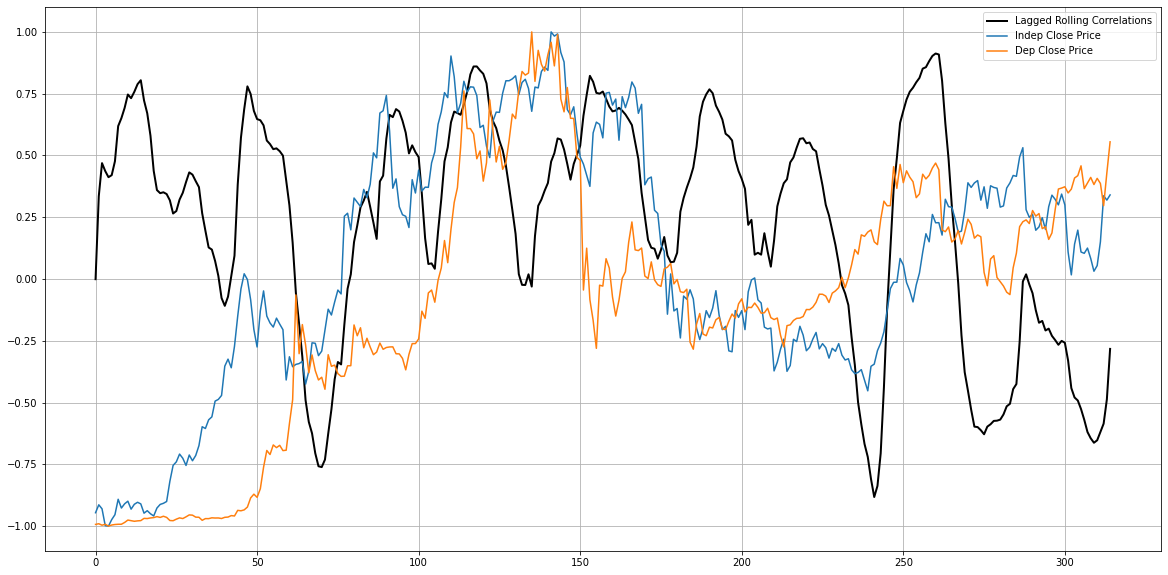

In [239]:
plt.figure(figsize=(20,10))
plt.plot(lag_roll_pears.values, "-k", label="Lagged Rolling Correlations", linewidth=2)
plt.plot(minmax_scale(indep.loc[idx_of_interest].values, (-1, 1)), label="Indep Close Price")
plt.plot(minmax_scale(dep.loc[trading_idx].values, (-1, 1)), label="Dep Close Price")
#plt.plot(dep_volume_scaled, label="Indep Volume")
plt.legend(loc="best")
plt.grid()
plt.show()

# Fitting 2 Sinewaves to data?

In [21]:
import numpy, scipy.optimize
import pylab as plt
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])
    guess = np.append(guess, guess)

    def doublesinfunc(t, A, w, p, c, A2, w2, p2, c2):  return (A * numpy.sin(w*t + p) + c) + (A2 * numpy.sin(w2*t + p2) + c2)
    popt, pcov = scipy.optimize.curve_fit(doublesinfunc, tt, yy, p0=guess)
    A, w, p, c, A2, w2, p2, c2 = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: (A * numpy.sin(w*t + p) + c) + (A2 * numpy.sin(w2*t + p2) + c2)
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

tt = np.arange(0, len(lag_roll_pears), 1)
yy = lag_roll_pears
res = fit_sin(tt, yy)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

Amplitude=0.2493381269269311, Angular freq.=0.14896957507734185, phase=6.739315075053622, offset=-4.590125508090971, Max. Cov.=1705269590251.6182


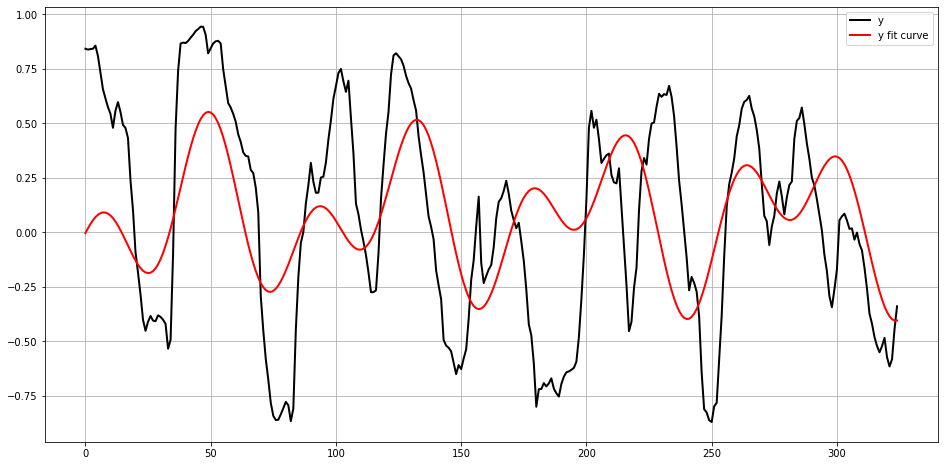

In [22]:
plt.figure(figsize=(16,8))
plt.plot(tt, yy, "-k", label="y", linewidth=2)
plt.plot(tt, res["fitfunc"](tt), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.grid()
plt.show()

## Attempting to Analyse Power Spectral Density of Lagged Correlations (looking for harmonic frequencies - recurring correlation patterns)

- Plot Autocorrelation
- Plot normalised power spectral density

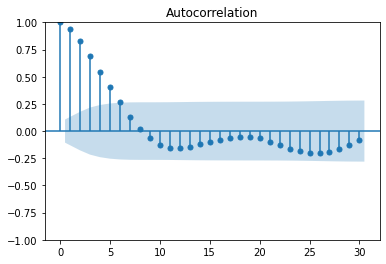

In [159]:
autocorr = []

for i in range(1, 160):
    shifted = lag_roll_pears.shift(i).dropna()
    autocorr.append(np.corrcoef(shifted, lag_roll_pears[-len(shifted):])[0][1])
    
plot_acf(lag_roll_pears, lags=30)
plt.show()

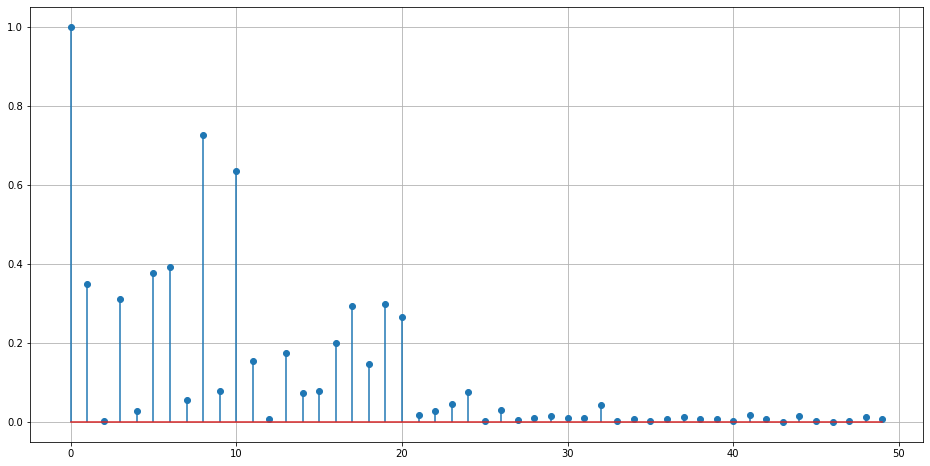

In [158]:
f = fft((np.array(lag_roll_pears)))
frq = f*np.conj(f)
norm_frq = np.abs(frq)/np.max(np.abs(frq))

plt.figure(figsize=(16, 8))
plt.stem(norm_frq[:50])
plt.grid()

In [144]:
ACF = acf(lag_roll_pears) # ACF
PSD = fft(ACF) # PSD

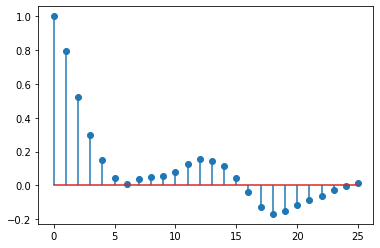

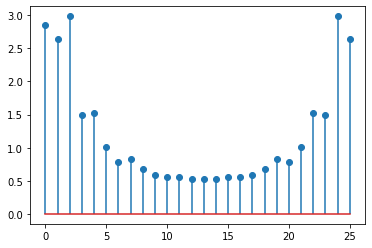

In [145]:
plt.stem(ACF)
plt.show()
plt.stem(np.abs(PSD))
plt.show()

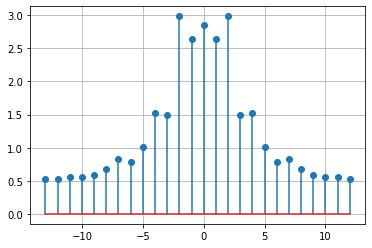

In [146]:
q = np.abs(PSD[0:13])
p = np.abs(PSD[13:])
x = np.arange(-len(PSD)/2 , len(PSD)/2  , 1)
plt.stem(x, np.append(p, q))
plt.grid()